In [1]:
import nibabel as nib
import numpy as np
from model.utils import *
import torch
import matplotlib.pyplot as plt
import model.SIMBA_VI as SIMBA_VI
import model.SIMBA_Gibbs as SIMBA_Gibbs
from nilearn.plotting import plot_stat_map,view_img

### Load data

In [2]:
### template
data_path = 'data/NARPS'
mni_img = nib.load(f'{data_path}/MNI152_2009_template_SSW.nii.gz')
mni_data = mni_img.get_fdata()[:, :, :, 0, 0]  # Extract the 0-th volume
target_affine = mni_img.affine
x,y,z = (mni_data).nonzero()

### mask
mask_path = f'{data_path}/group_mask.inter.nii.gz'
mask_img = nib.Nifti1Image.from_filename(mask_path)
mask = nib.Nifti1Image.from_filename(mask_path).get_fdata()

In [3]:
### preproced
narps = load_pickle('data/NARPS/data.pickle')
data = narps['data']
x,y,z = narps['coord']
S = narps['S']
N, V = data.shape
dtype = torch.float32

Pickle loaded from data/NARPS/data.pickle


In [4]:
from sklearn.gaussian_process.kernels import RBF, Matern
### specify kernel function
ls = 0.1
kernel = Matern(length_scale=ls, nu=1.5)

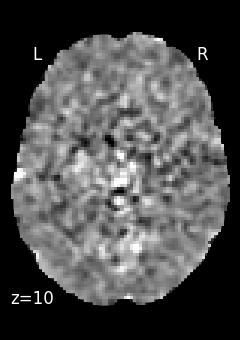

In [5]:
post_map = np.zeros(mask_img.shape)
post_map[x, y, z] = data[0]
post_map_img = nib.Nifti1Image(post_map, mask_img.affine)
fig=plot_stat_map(post_map_img,
              bg_img=nib.Nifti1Image(mni_data, mni_img.affine),
              colorbar=False,
              threshold=0,
               cbar_tick_format="%.3f",
              vmax=0.03, vmin=-0.03,
            cmap='gray',
            display_mode='z',
             #cmap = base_cmap,
              cut_coords=[ 10])


#### Get a grid of L based on the variance explained by eigenvalues

In [6]:
# full_cov = kernel(S[:15000],S[:15000])
# U,lamb_sqrt,_ = np.linalg.svd(full_cov)

# cumsum = np.cumsum(lamb_sqrt, axis=0)
# total = np.sum(lamb_sqrt)
# lower = np.nonzero(cumsum >= 0.8 * total)[0][0]
# upper = np.nonzero(cumsum >= 0.98 * total)[0][0]
# L_list = np.linspace(lower, upper,num=10, dtype=int)
# L_list #array([ 224,  471,  719,  967, 1214, 1462, 1710, 1957, 2205, 2453])

# del full_cov, U, lamb_sqrt

In [7]:
# N, V = data.shape
# n_ind = torch.arange(0,N)
# vi_results = []
# for L in L_list:
#     print(L)
#     L_eta = int(0.1*L)
#     mse = []
#     mae = []
#     for i in range(N):
#         Y_i = data[np.where(n_ind != i)]
#         model = SIMBA_VI.SIMBA_VI(Y=Y_i, X= None, grids=S,
#                                  kernel = kernel, L = L, L_eta = L_eta, 
#                                  verbose=-1, include_intercept=False)
#         paras, profile = model.run(verbose=False)

#         Y_pred =  paras['E_alpha'] + (paras['E_theta_beta'] @ model.basis.t())
#         mse.append(((Y_pred - data[i]) ** 2).mean())
#         mae.append((Y_pred - data[i]).abs().mean())
#         del model
#     vi_results.append({'L': L, 'MSE': np.mean(mse),'MAE':np.mean(mae)})

In [8]:
L = 1214
L_eta = int(0.1*L)

In [9]:
model = SIMBA_VI.SIMBA_VI(
    Y=data, X= None,
    grids=S, kernel=kernel, L = L, L_eta = L_eta,verbose=5000,
    dtype=dtype, ELBO_diff_tol=1e-8,para_diff_tol = 1e-8, elbo_stop=True,max_iter=50000
)
paras, profile = model.run()

iter: 0, ELBO: 73043.09375
Used iter 2744 finished in 5.40 seconds


In [10]:
eff_est = paras['E_alpha'][:,None] + paras['E_theta_beta'] @ model.basis.t()
voxel_mcmc = model.get_eff_mcmc()
P_pos = (( voxel_mcmc > 0) * 1.0).mean(0) ## calcualte P+
E_s = (P_pos - 0.5) * 2
select = (E_s.abs() > 0.95) * 1
eff_sig = eff_est * select

In [12]:
post_map = np.zeros(mask_img.shape, dtype=np.float32)
post_map[x, y, z] = eff_est.numpy().astype(np.float32)
post_map_img = nib.Nifti1Image(post_map, affine=mask_img.affine, dtype=np.float32)
post_map_img.header['qform_code'] = 4
post_map_img.header['sform_code'] = 4
nib.save(post_map_img, f'data/NARPS/results/narps_SIMBA_VI_posterior_mean.nii.gz')

In [13]:
post_map = np.zeros(mask_img.shape, dtype=np.float32)
post_map[x, y, z] = E_s.numpy().astype(np.float32)
post_map_img = nib.Nifti1Image(post_map, affine=mask_img.affine, dtype=np.float32)
post_map_img.header['qform_code'] = 4
post_map_img.header['sform_code'] = 4
nib.save(post_map_img, f'data/NARPS/results/narps_SIMBA_VI_posterior_Es.nii.gz')

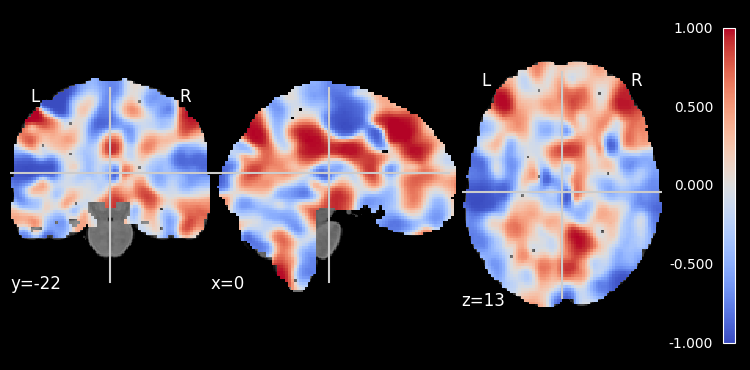

In [14]:
post_map = np.zeros(mask_img.shape)
post_map[x, y, z] = E_s
post_map_img = nib.Nifti1Image(post_map, mask_img.affine)
fig=plot_stat_map(post_map_img,
              bg_img=nib.Nifti1Image(mni_data, mni_img.affine),
              colorbar=True,
              threshold=0,
               cbar_tick_format="%.3f",
              #vmax=0.003, vmin=-0.003,
            cmap='coolwarm',
             #cmap = base_cmap,
              cut_coords=[0, -22, 13])



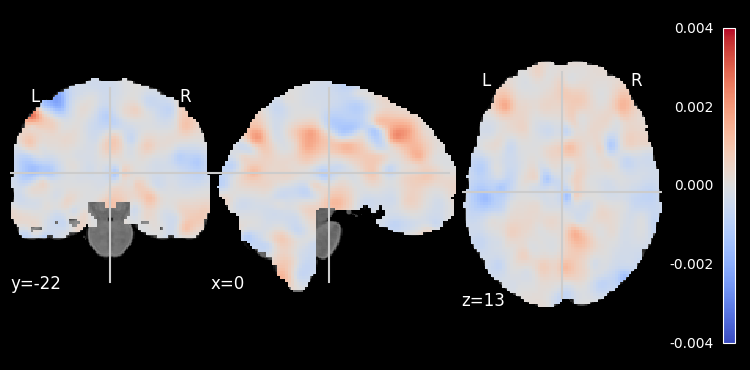

In [15]:
post_map = np.zeros(mask_img.shape)
post_map[x, y, z] = eff_est
post_map_img = nib.Nifti1Image(post_map, mask_img.affine)
fig=plot_stat_map(post_map_img,
              bg_img=nib.Nifti1Image(mni_data, mni_img.affine),
              colorbar=True,
              threshold=0,
               cbar_tick_format="%.3f",
              #vmax=0.003, vmin=-0.003,
            cmap='coolwarm',
             #cmap = base_cmap,
              cut_coords=[0, -22, 13])



#### Generate PPC curves

In [16]:
ppc = model.PPC(n_mcmc=150)
ppc = ppc.reshape(-1, N, V) # flatten chains
ppc.shape

torch.Size([150, 47, 222230])

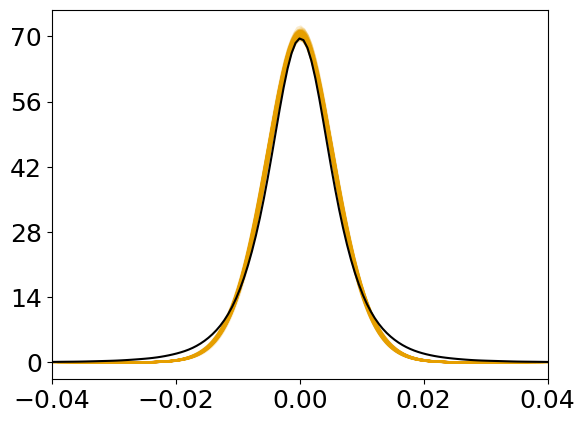

In [17]:
from fastkde import fastKDE
## takes about 3 mins for 100 draws
for i in range(ppc.shape[0]):
    density = fastKDE.pdf(ppc[i].reshape(-1),ecf_precision=1) # flat to vector
    density.plot(alpha=0.2, color="#E69F00", label='Posterior predictive' if i == 0 else None)
data_den= fastKDE.pdf(data.reshape(-1),ecf_precision=1)
data_den.plot(alpha=1.0, color="black", label='Observed data')
plt.xlim(-0.04, 0.04)  

plt.ylabel('')
plt.xlabel('')
plt.xticks(np.linspace(-0.04, 0.04, 5), fontsize=18)
plt.yticks(np.linspace(0, 70, 6),fontsize=18)


# plt.savefig(f'plots/narps/BSHE_VI_ppc_J{L}_eta{L_eta}.png', dpi=300, bbox_inches='tight')  
plt.show()

In [18]:
model = SIMBA_Gibbs.SIMBA_Gibbs( Y=data,
    grids=S, kernel=kernel,  L = L, L_eta = L_eta,
    burnin=4000,
    mcmc_sample=1000,
    thin=1,
    dtype=dtype)
samples = model.run(n_chains=3, parallel = False)

100%|██████████| 5000/5000 [01:20<00:00, 62.08it/s]


Chain 1 finished in 80.55 seconds


100%|██████████| 5000/5000 [01:22<00:00, 60.41it/s]


Chain 2 finished in 82.77 seconds


100%|██████████| 5000/5000 [01:26<00:00, 57.55it/s]


Chain 3 finished in 86.88 seconds


In [19]:
voxel_mcmc = samples['alpha'][:,:,None] + samples['theta_beta'] @ model.basis.t()
P_pos = (( voxel_mcmc > 0) * 1.0).mean(dim=(0,1)) ## calcualte P+
E_s = (P_pos - 0.5) * 2
select = (E_s.abs() > 0.95) * 1
eff_sig = eff_est * select
mean = voxel_mcmc.mean(dim=(0,1))
std = voxel_mcmc.std(dim=(0,1))
z_score = mean / std

In [20]:
voxel_mcmc.mean((0,1)).shape

torch.Size([1, 222230])

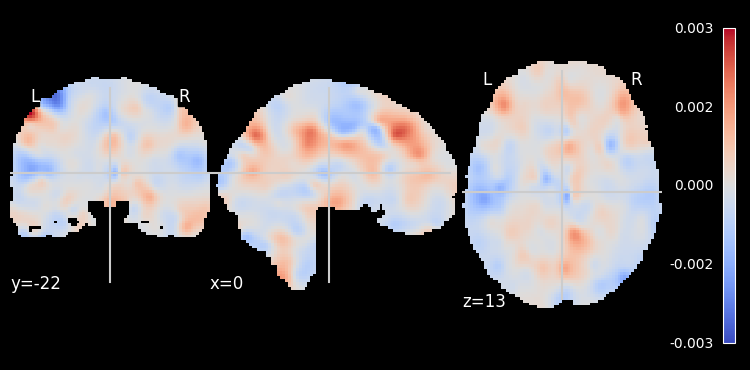

In [21]:
post_map = np.zeros(mask_img.shape)
post_map[x, y, z] = mean
post_map_img = nib.Nifti1Image(post_map, mask_img.affine)
fig=plot_stat_map(post_map_img,
              bg_img=nib.Nifti1Image(mask, mask_img.affine),
              colorbar=True,
              threshold=0,
               cbar_tick_format="%.3f",
              vmax=0.003, vmin=-0.003,
             cmap='coolwarm',
              cut_coords=[0, -22, 13])

In [22]:
post_map = np.zeros(mask_img.shape, dtype=np.float32)
post_map[x, y, z] = mean.numpy().astype(np.float32)
post_map_img = nib.Nifti1Image(post_map, affine=mask_img.affine, dtype=np.float32)
post_map_img.header['qform_code'] = 4
post_map_img.header['sform_code'] = 4
nib.save(post_map_img, f'data/NARPS/results/narps_SIMBA_Gibbs_posterior_mean.nii.gz')

In [23]:
post_map = np.zeros(mask_img.shape, dtype=np.float32)
post_map[x, y, z] = E_s.numpy().astype(np.float32)
post_map_img = nib.Nifti1Image(post_map, affine=mask_img.affine, dtype=np.float32)
post_map_img.header['qform_code'] = 4
post_map_img.header['sform_code'] = 4
nib.save(post_map_img, f'data/NARPS/results/narps_SIMBA_Gibbs_posterior_Es.nii.gz')

In [26]:
ppc = model.PPC(n_samples=50)
ppc = ppc.reshape(-1, N,V)
ppc.shape

torch.Size([150, 47, 222230])

In [27]:
ppc.shape

torch.Size([150, 47, 222230])

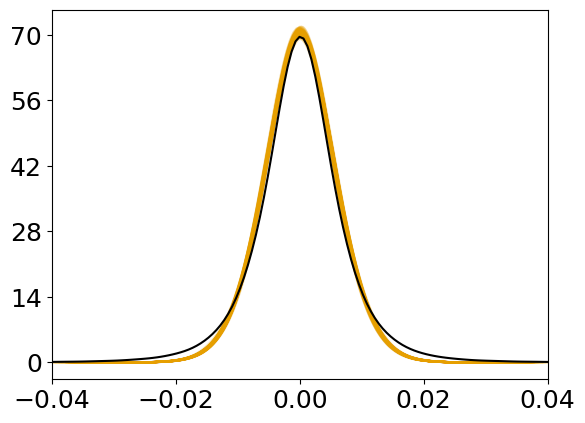

In [28]:
from fastkde import fastKDE
## takes about 3 mins for 100 draws
for i in range(ppc.shape[0]):
    density = fastKDE.pdf(ppc[i].reshape(-1),ecf_precision=1) # flat to vector
    density.plot(alpha=0.2, color="#E69F00", label='Posterior predictive' if i == 0 else None)
data_den= fastKDE.pdf(data.reshape(-1),ecf_precision=1)
data_den.plot(alpha=1.0, color="black", label='Observed data')
plt.xlim(-0.04, 0.04)  

plt.ylabel('')
plt.xlabel('')
plt.xticks(np.linspace(-0.04, 0.04, 5), fontsize=18)
plt.yticks(np.linspace(0, 70, 6),fontsize=18)

# # Add legend (only one entry for grey lines)
# plt.legend(
#     loc='upper center',
#     fontsize=24,
#     bbox_to_anchor=(0.5, 1.15),  # center above axes
#     ncol=2,                      # number of legend columns
#     frameon=False                # no border
# )

#plt.savefig(f'plots/Gibbs_ppc_L{L}.png', dpi=300, bbox_inches='tight')  
plt.show()